# MeerKAT as a Phased Array

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.signal import find_peaks

from timeit import default_timer as timer
from datetime import timedelta

# ---------- Matplotlib Settings ----------

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

sns.set_context("notebook", font_scale=1)

from IPython.display import set_matplotlib_formats

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import matplotlib.pylab as pylab

params = {
    'axes.titlesize':'xx-large',
    'axes.labelsize': 'xx-large',
    'xtick.labelsize':'large',
    'ytick.labelsize':'large',
    'legend.fontsize': 'large',
    'lines.linewidth': 2.5
}

pylab.rcParams.update(params)

# -----------------------------------------

from phasedarraylib.arrays import Array, RandomCircularArray
from phasedarraylib.utilities import decibel, arg_closest

## MeerKAT Position Data

In [2]:
positions = pd.read_csv('MeerKAT_antenna_positions.csv', sep=',', skiprows=17, nrows=64, usecols=[1, 2, 3], names=['east', 'north', 'up'])

positions['east-north'] = np.sqrt(positions['east'] ** 2 + positions['north'] ** 2)

positions.head()

,east,north,up,east-north
0,-8.264,-207.290,8.597,207.454664
1,1.121,-171.762,8.471,171.765658
2,-32.113,-224.236,8.645,226.523792
3,-66.518,-202.276,8.285,212.932441
4,-123.624,-252.946,8.513,281.539646


## The MeerKAT Array

For more info on MeerKAT: https://skaafrica.atlassian.net/wiki/spaces/ESDKB/pages/277315585/MeerKAT+specifications

In [3]:
frequency = 580 # MHz

In [4]:
meerkat = Array()

meerkat_positions = positions[['east', 'north']].to_numpy()
meerkat.set_element_positions(meerkat_positions)

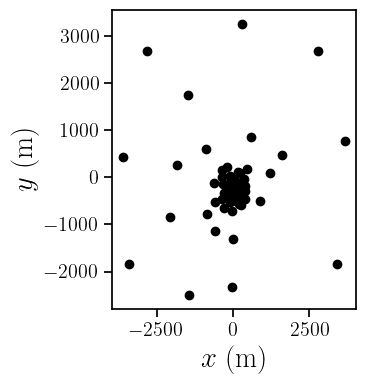

In [5]:
meerkat.plot_configuration()

## Antenna Selection

In [57]:
def inner_select(antenna_count, dataframe):
    size = dataframe.shape[0]
    
    p_sorted = dataframe.sort_values('east-north')
    
    return p_sorted[:antenna_count]

def outer_select(antenna_count, dataframe):
    size = dataframe.shape[0]
    
    p_sorted = dataframe.sort_values('east-north')
    
    n_ant = size - antenna_count
    
    return p_sorted[n_ant:]

## Array Response

In [6]:
uv_modifier = 200

uv_extent = 1/uv_modifier
uv_range = (-uv_extent, uv_extent)

In [27]:
start = timer()

response = meerkat.evaluate_array_factor(frequency, extent=uv_range, sample_count=512 + 1)

end = timer()
dt = timedelta(seconds=end-start)

print('finished evaluating the array factor for u, v on [{}, {}] in {}'.format(*uv_range, dt))

finished evaluating the array factor for u, v on [-0.005, 0.005] in 0:00:09.218145


### 2D Beam

In [28]:
af = response.get('af')
af /= af.max()

af_db = decibel(af)

print('AF_min (dB) = {}'.format(af_db.min()))

AF_min (dB) = -73.75357484343512


### 1D Beam

In [29]:
af_2d = response.get('af')
af_u = af_2d[af_2d.shape[0]//2, :]
af_v = af_2d[:, af_2d.shape[1]//2]

u_vals = response.get('u')

ba = np.pi/2 - np.arccos(u_vals)
ba_deg = np.degrees(ba)
ba_arcmin = ba_deg * 60
ba_arcsec = ba_arcmin * 60

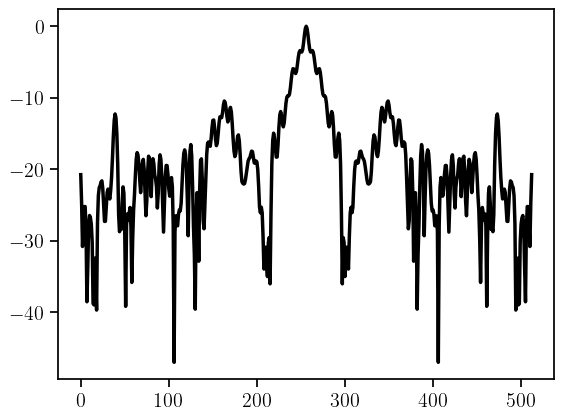

In [30]:
plt.plot(decibel(af_u), color='black')

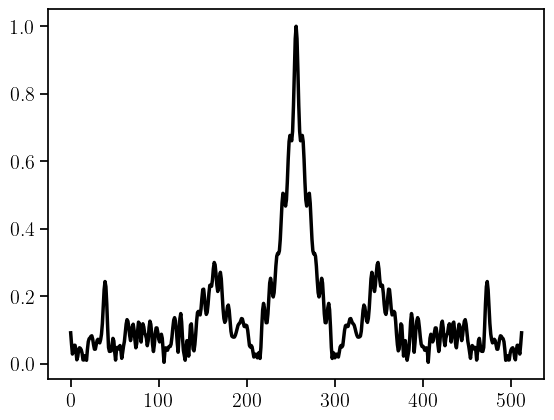

In [31]:
plt.plot(np.abs(af_u), color='black')

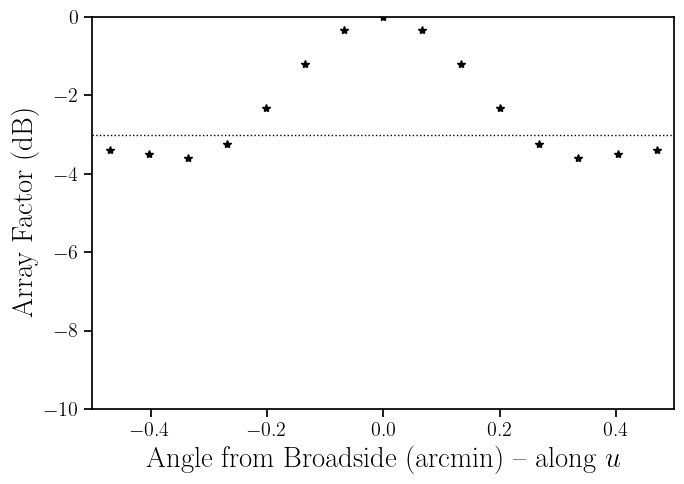

In [59]:
fig, frame = plt.subplots(figsize=(7, 5))

# frame.plot(ba_arcmin, decibel(af_v), lw=1, color='black')
frame.plot(ba_arcmin, decibel(af_u), marker='*', ls='', lw=1, color='black')
frame.axhline(y=-3, color='black', ls=':', lw=1)

frame.update(dict(
    xlabel=r'Angle from Broadside (arcmin) -- along $u$',
    ylabel=r'Array Factor (dB)',
    xlim=(-0.5, 0.5),
    # xlim=(ba_arcmin.min(), ba_arcmin.max()),
    # xticks=np.arange(-1, 1.5, 0.5),
    # ylim=(-40, 0)
    ylim=(-10, 0)
))

fig.tight_layout()
plt.show()

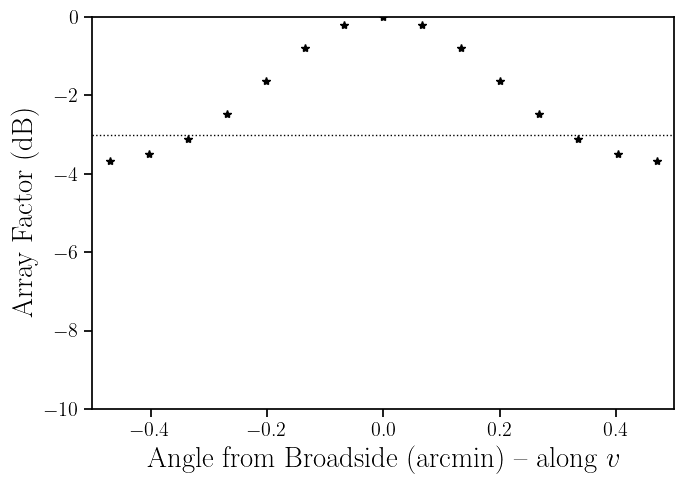

In [60]:
fig, frame = plt.subplots(figsize=(7, 5))

# frame.plot(ba_arcmin, decibel(af_v), lw=1, color='black')
frame.plot(ba_arcmin, decibel(af_v), marker='*', ls='', lw=1, color='black')
frame.axhline(y=-3, color='black', ls=':', lw=1)

frame.update(dict(
    xlabel=r'Angle from Broadside (arcmin) -- along $v$',
    ylabel=r'Array Factor (dB)',
    xlim=(-0.5, 0.5),
    # xlim=(ba_arcmin.min(), ba_arcmin.max()),
    # xticks=np.arange(-1, 1.5, 0.5),
    # ylim=(-40, 0)
    ylim=(-10, 0)
))

fig.tight_layout()
plt.show()

In [34]:
import scipy.optimize as opt

In [45]:
def root_u(x):
    af_max = np.abs(meerkat.array_factor(0, 0, frequency))
    af = np.abs(meerkat.array_factor(x, 0, frequency))
    
    af_n = af/af_max
    
    return np.power(af_n, 2) - 0.5

def root_v(x):
    af_max = np.abs(meerkat.array_factor(0, 0, frequency))
    af = np.abs(meerkat.array_factor(0, x, frequency))
    
    af_n = af/af_max
    
    return np.power(af_n, 2) - 0.5

ru = opt.brentq(root_u, 1e-10, 1)
rv = opt.brentq(root_v, 1e-10, 1)

In [47]:
hpbw_along_u(meerkat)

29.793414118284314

In [36]:
hpbw_u = 2*np.degrees(np.pi/2 - np.arccos(ru)) * 60 * 60
hpbw_v = 2*np.degrees(np.pi/2 - np.arccos(rv)) * 60 * 60

In [37]:
print('HPBW = {:.3f} arcsec - along u'.format(hpbw_u))
print('HPBW = {:.3f} arcsec - along v'.format(hpbw_v))

HPBW = 29.793 arcsec - along u
HPBW = 38.548 arcsec - along v


In [38]:
np.pi/2 - np.arccos(ru)

7.222127385753119e-05

In [39]:
np.pi/2 - np.arccos(rv)

9.344404416133933e-05

In [46]:
def hpbw_along_u(array):
    def root(u):
        af_max = np.abs(array.array_factor(0, 0, frequency))
        af = np.abs(array.array_factor(u, 0, frequency))

        af_n = af/af_max

        return np.power(af_n, 2) - 0.5
    
    r = opt.brentq(root, 1e-10, 1)
    
    hpbw = 2*np.degrees(np.pi/2 - np.arccos(r)) * 60 * 60
    
    return hpbw

In [88]:
hpbw_list = []
ant_counts = np.arange(8, 64 + 4, 4)
plot_config = False

for ant_count in ant_counts:
    meerkat_subarray = Array()

    selected_positions = inner_select(ant_count, positions)
    m_positions = selected_positions[['east', 'north']].to_numpy()
    meerkat_subarray.set_element_positions(m_positions)
    
    if plot_config:
        meerkat_subarray.plot_configuration()
    
    hpbw_u = hpbw_along_u(meerkat_subarray)
    hpbw_list.append(hpbw_u)

In [89]:
hpbw_list_outer = []
ant_counts = np.arange(8, 64 + 4, 4)
plot_config = False

for ant_count in ant_counts:
    meerkat_subarray = Array()

    selected_positions = outer_select(ant_count, positions)
    m_positions = selected_positions[['east', 'north']].to_numpy()
    meerkat_subarray.set_element_positions(m_positions)
    
    if plot_config:
        meerkat_subarray.plot_configuration()
    
    hpbw_u = hpbw_along_u(meerkat_subarray)
    hpbw_list_outer.append(hpbw_u)

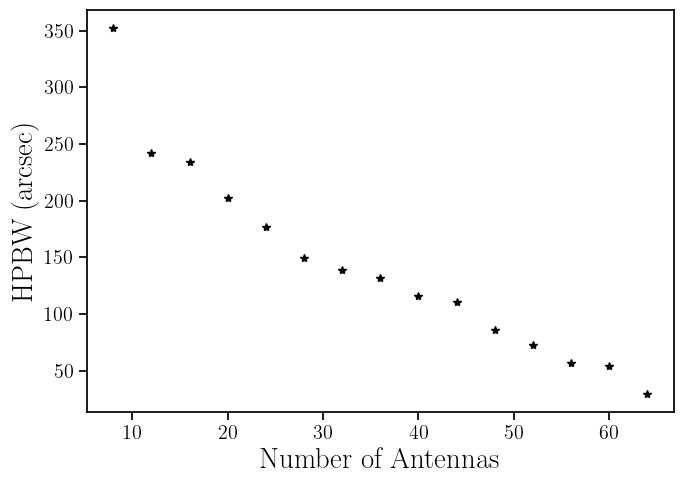

In [97]:
fig, frame = plt.subplots(figsize=(7, 5))

frame.plot(ant_counts, hpbw_list, marker='*', ls='', lw=1, color='black', label='Outward')

frame.update(dict(
    xlabel=r'Number of Antennas',
    ylabel=r'HPBW (arcsec)',
))

# fig.legend()

fig.tight_layout()
plt.show()

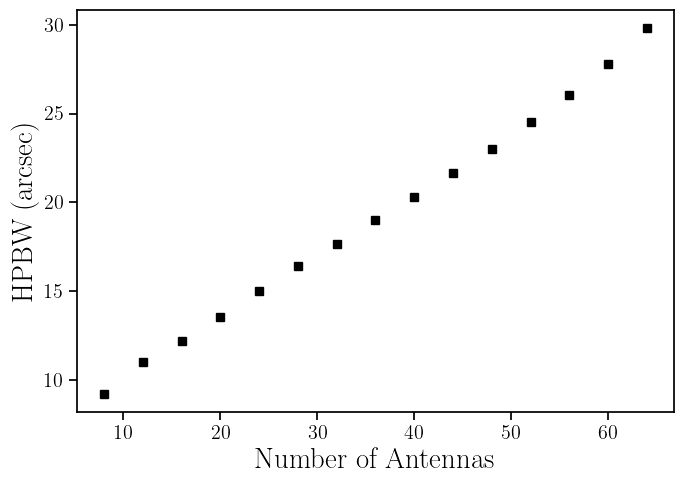

In [98]:
fig, frame = plt.subplots(figsize=(7, 5))

frame.plot(ant_counts, hpbw_list_outer, marker='s', ls='', lw=1, color='black', label='Inward')

frame.update(dict(
    xlabel=r'Number of Antennas',
    ylabel=r'HPBW (arcsec)',
))

fig.tight_layout()
plt.show()

### Half Power Beam Width

Find the indices where the AF (in dB) along a particular axis is equal to -3...

In [40]:
def approx_hpbw(af, angles):
    idx_half = af.size // 2
    
    af_db = decibel(af)
    
    idx_left, err_left = arg_closest(af_db[:idx_half], -3)
    idx_right, err_right = arg_closest(af_db[idx_half:], -3)

    idx_right = idx_right + idx_half
    
    bw_left = angles[idx_left]
    bw_right = angles[idx_right]
    
    hpbw = np.abs(bw_right - bw_left)
    
    return hpbw

In [41]:
hpbw_u = approx_hpbw(af_u, ba_arcmin)
hpbw_v = approx_hpbw(af_v, ba_arcmin)

print('HPBW = {:.3f} arcmin - along u'.format(hpbw_u))
print('HPBW = {:.3f} arcmin - along v'.format(hpbw_v))

HPBW = 0.537 arcmin - along u
HPBW = 0.671 arcmin - along v


### Null-Null Beam Width

To estimate the main beam solid angle, assume

$$\Omega_\text{MB}\sim \pi\left(\frac{\text{NNBW}}{2}\right)^2$$

In [20]:
def approx_nnbw(af, angles, db_threshold=30):
    peaks, _ = find_peaks(-decibel(af_u), height=abs(db_threshold))
    
    hidx = af.size // 2
    
    ln_idx = peaks[peaks<hidx][-1]
    rn_idx = peaks[peaks>hidx][0]
    
    lw = angles[ln_idx]
    rw = angles[rn_idx]
    
    hpbw = np.abs(rw - lw)
    
    return hpbw

In [21]:
nnbw_u = approx_nnbw(af_u, ba_arcmin)
nnbw_v = approx_nnbw(af_v, ba_arcmin)

print('NNBW = {:.3f} arcmin - along u'.format(nnbw_u))
print('NNBW = {:.3f} arcmin - along v'.format(nnbw_v))

NNBW = 5.500 arcmin - along u
NNBW = 5.500 arcmin - along v


In [22]:
# fig, frame = plt.subplots(figsize=(7, 5))

# frame.plot(ba_arcmin, decibel(af_u), lw=1, color='black')
# frame.plot(ba_arcmin[peaks], decibel(af_u)[peaks], ls='', marker='o', color='black')
# # frame.plot(ba_arcmin, decibel(af_u), marker='*', ls='', lw=1, color='black')
# frame.axhline(y=-3, color='black', ls=':', lw=1)

# frame.update(dict(
#     xlabel=r'Angle from Broadside (arcmin) -- along $u$',
#     ylabel=r'Array Factor (dB)',
#     xlim=(ba_arcmin.min(), ba_arcmin.max()),
#     # xticks=np.arange(-1, 1.5, 0.5),
#     # ylim=(-40, 0)
# ))

# # frame.update(dict(
# #     xlabel=r'Angle from Broadside (arcmin) -- along $u$',
# #     ylabel=r'Array Factor (dB)',
# #     xlim=(-0.5, 0.5),
# #     # xlim=(ba_arcmin.min(), ba_arcmin.max()),
# #     # xticks=np.arange(-1, 1.5, 0.5),
# #     # ylim=(-40, 0)
# #     ylim=(-10, 0)
# # ))

# frame.grid(alpha=0.2)

# fig.tight_layout()
# plt.show()